<a href="https://colab.research.google.com/github/SirxChinni/Modulation-Classification-Based-on-Signal-Constellation-Diagrams-and-Deep-Learning/blob/main/Automatic_Modulation_Classification_using_Constellation_Diagrams_and_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")
root_path = "/content/gdrive/My Drive/mod_rec/"

Mounted at /content/gdrive/


In [ ]:
%tensorflow_version x.x
import joblib
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Conv2D, Input, Concatenate, Add, PReLU
from keras.layers import MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.initializers import glorot_uniform, Constant
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from scipy.interpolate import UnivariateSpline
from keras.utils import to_categorical
from sklearn import preprocessing
from keras.optimizers import Adam
from keras import regularizers


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Variables used for training the models



In [ ]:
EPOCHS = 100
NUM_CLASSES = 8
BATCH_SIZE = 64 #constellation images
PATIENCE = 4 #constellation takes quite long to train

\## Functions for generating and plotting confusion matrices


In [ ]:
def generate_confusion_matrix(model, X,y, one_hot_transformer, batch_size):
    """
      y is the one hot encoded label vector passed to the model.evaluate
    """
    mod_to_idx = {mod:idx for idx,mod in enumerate(one_hot_transformer.classes_)} # use this to map modulation name to index
    y_hat = model.predict(X, batch_size)
    y_hat_onehot = np.zeros_like(y_hat)
    y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
    y_hat_mod = one_hot_transformer.inverse_transform(y_hat_onehot) # transform predictions to strings
    y_mod = one_hot_transformer.inverse_transform(y) # transform ground truth back to strings
    confusion_mat = np.zeros([NUM_CLASSES,NUM_CLASSES])

    acc = np.mean(y_mod == y_hat_mod)
    # fill in the confusion matrix
    for i in range(y.shape[0]):

        true_idx = mod_to_idx[y_mod[i]]
        pred_idx = mod_to_idx[y_hat_mod[i]]
        confusion_mat[pred_idx,true_idx] += 1

    # normalize the matrix column wise
    for i in range(NUM_CLASSES):
        if np.sum(confusion_mat[:,i]) > 0:
          confusion_mat[:,i] /= np.sum(confusion_mat[:,i])

    return confusion_mat,acc


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells

  plt.title(title)
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.ylabel('Predicted label')
  plt.xlabel('True label')

## Label encoder class of functions

In [ ]:
#created my own LabelBinarizer class so can encode both 2-class and multiclass cases
class MyLabelBinarizer(preprocessing.LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y

    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

Model

In [ ]:
class ModelEvaluater:
  def __init__(self, model, X_train, y_train, X_val, y_val, X_test, y_test,
               labels_test, batch_size, model_name, channels_first=True, feature_type=1):
    if channels_first:
      self.X_train = X_train
      self.X_val = X_val
      self.X_test = X_test
    else:
      self.X_train = X_train.reshape([X_train.shape[0], X_train.shape[2], X_train.shape[1]])
      self.X_val = X_val.reshape([X_val.shape[0], X_val.shape[2], X_val.shape[1]])
      self.X_test = X_test.reshape([X_test.shape[0], X_test.shape[2], X_test.shape[1]])

    self.feature_type = feature_type

    self.model = model
    self.y_train = y_train
    self.y_val = y_val
    self.y_test = y_test
    self.labels_test = labels_test
    self.model_name = model_name
    self._checkpoint_callback = ModelCheckpoint(filepath=root_path + '%s-weights-{epoch}.hdf5' % self.model_name,
                                                verbose=1, save_best_only=True)
    self._train_accs = []
    self._val_accs = []
    self._snr_accs = []

    self.batch_size = batch_size

    # get the modulation types into an array
    self.mod_types = np.unique(labels_test[:,0])

    # fit a label binarizer
    self.mod_to_onehot = MyLabelBinarizer()
    self.mod_to_onehot.fit(self.mod_types)

    # transform the y values to one-hot encoding
    self.y_train = self.mod_to_onehot.transform(y_train)
    self.y_val = self.mod_to_onehot.transform(y_val)
    self.y_test = self.mod_to_onehot.transform(y_test)

    print('y_train %s' %(y_train.shape))
    print('y_val %s' %(y_val.shape))
    print('y_test %s' %(y_test.shape))



  def fit(self, epochs, patience=10):
    curr_X, curr_y = self.X_train, self.y_train
    val_X, val_y = self.X_val, self.y_val
    callbacks = [self._checkpoint_callback, EarlyStopping(patience=patience)]

     # train the model
    model_info = self.model.fit(curr_X, curr_y,
                                batch_size=self.batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(val_X, val_y),
                                callbacks=callbacks)

    self._train_accs.extend(model_info.history['accuracy'])
    self._val_accs.extend(model_info.history['val_accuracy'])



  def print_summary(self):
    # plot validation accuracy vs training accuracy
    plt.plot(np.arange(len(self._train_accs)), self._train_accs, '-o', label='training accuracy')
    plt.plot(np.arange(len(self._val_accs)), self._val_accs, '-o', label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.title('%s -validation vs training accuracy' %(self.model_name))
    display(plt.show())

    #plot confusion matrix for all, low, med and high SNR
    snr_ranges = [(-20, 20),(18, 18), (6, 20)]
    for snr_rng in snr_ranges:
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_,
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

    # get accuracy per snr
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    # plot the accuracy against the snr
    plt.plot(list(snr_accs.keys()),list(snr_accs.values()))
    plt.xlabel("Signal to Noise Ratio")
    plt.ylabel("Classification Accuracy")
    plt.xticks(list(snr_accs.keys()))
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.grid(True)
    plt.show()


  def accpersnr_model(self):
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    return snr_accs

# Loading and formatting of data

RML 2016a

In [ ]:
data = joblib.load('/content/gdrive/My Drive/data/rml_trainvaltest.hdf5')

In [ ]:
#load data
X_train = data['train']['X']
y_train = data['train']['labels'][:,0]
labels_train = data['train']['labels']

X_val = data['val']['X']
y_val = data['val']['labels'][:,0]
labels_val = data['val']['labels']

X_test = data['test']['X']
y_test = data['test']['labels'][:,0]
labels_test = data['test']['labels']

# Convert data into constellation images of different form


Modulation type vs snr indexes

In [ ]:
modulation_names = labels_train[:, 0]
snr_ratios = labels_train[:, 1].astype(float)  # Assuming SNR ratios are stored as strings, convert to float

# Filter entries with SNR greater than 20
selected_indices = np.where(snr_ratios > 17)[0]

# Print the selected modulations and SNR ratios with their index numbers
for index in selected_indices:
    modulation = modulation_names[index]
    snr = snr_ratios[index]
    print(f"Index: {index}, Modulation: {modulation}, SNR: {snr}")

Streaming output truncated to the last 5000 lines.
Index: 8671, Modulation: GFSK, SNR: 18.0
Index: 8695, Modulation: 16QAM, SNR: 18.0
Index: 8706, Modulation: 64QAM, SNR: 18.0
Index: 8739, Modulation: 16QAM, SNR: 18.0
Index: 8740, Modulation: GFSK, SNR: 18.0
Index: 8741, Modulation: QPSK, SNR: 18.0
Index: 8804, Modulation: 8PSK, SNR: 18.0
Index: 8810, Modulation: QPSK, SNR: 18.0
Index: 8825, Modulation: BPSK, SNR: 18.0
Index: 8832, Modulation: QPSK, SNR: 18.0
Index: 8837, Modulation: GFSK, SNR: 18.0
Index: 8843, Modulation: QPSK, SNR: 18.0
Index: 8869, Modulation: 4PAM, SNR: 18.0
Index: 8880, Modulation: 4PAM, SNR: 18.0
Index: 8887, Modulation: GFSK, SNR: 18.0
Index: 8899, Modulation: 64QAM, SNR: 18.0
Index: 8919, Modulation: 4PAM, SNR: 18.0
Index: 8939, Modulation: 8PSK, SNR: 18.0
Index: 8947, Modulation: 64QAM, SNR: 18.0
Index: 8953, Modulation: GFSK, SNR: 18.0
Index: 8987, Modulation: 64QAM, SNR: 18.0
Index: 9018, Modulation: 64QAM, SNR: 18.0
Index: 9024, Modulation: 4PAM, SNR: 18.0

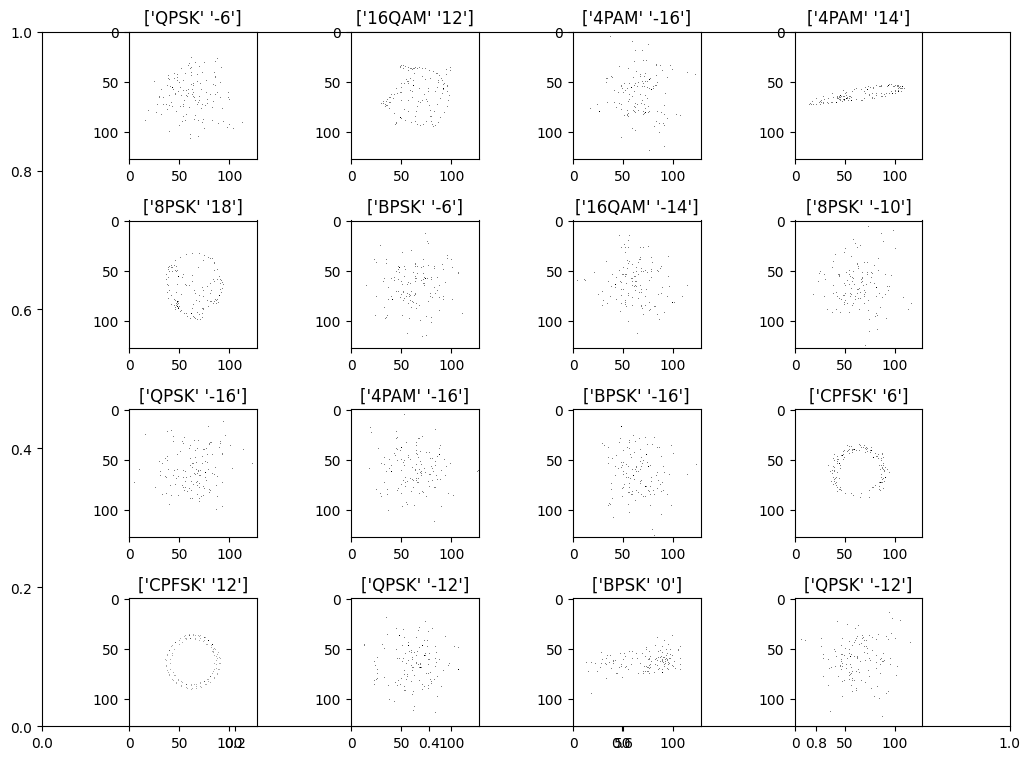

In [ ]:
nbins = 96
index = np.array([106368,106510,106533,106545,106548,106559,106577,106655])
i=0
counts, xedges, yedges = np.histogram2d(X_train[index[i]][0], X_train[index[i]][1], bins=nbins,range = [[-0.02, 0.02], [-0.02, 0.02]])
fig, ax = plt.subplots(figsize=(10,8))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    counts, xedges, yedges = np.histogram2d(X_train[i][0], X_train[i][1], bins=nbins,range = [[-0.02, 0.02], [-0.02, 0.02]])
    ax.imshow(counts, cmap='binary')
    ax.set_title(str(labels_train[i]))
    plt.tight_layout()
plt.show()

## Gray Model

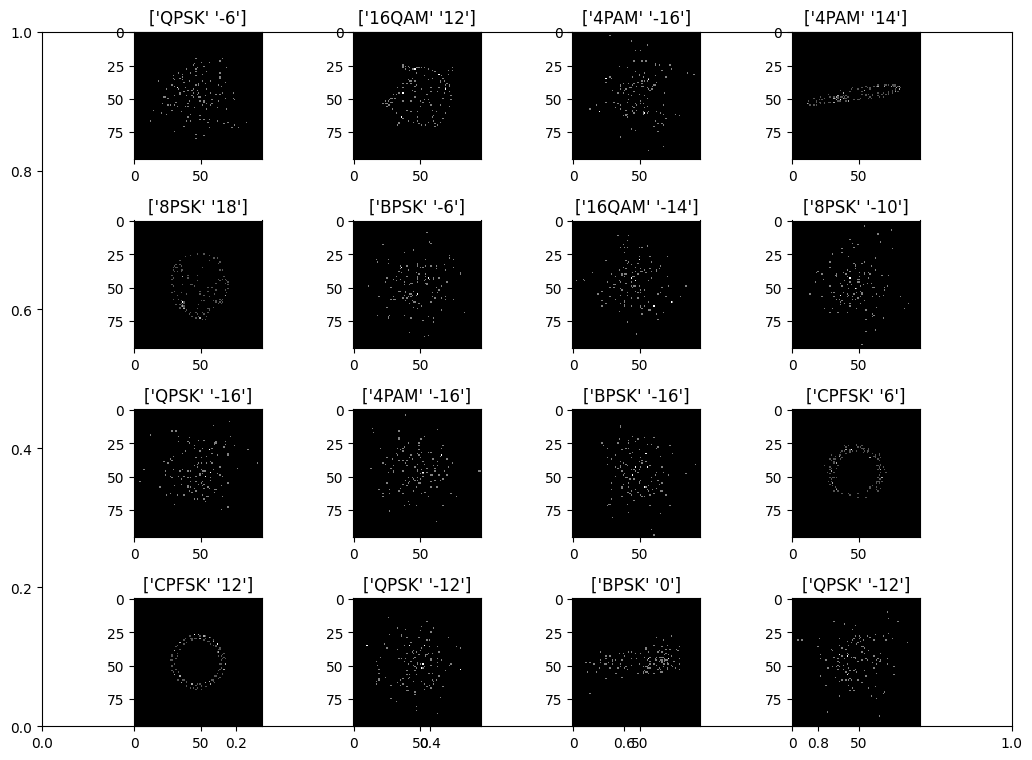

In [ ]:
nbins = 96

fig, ax = plt.subplots(figsize=(10,8))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    counts, xedges, yedges = np.histogram2d(X_train[i][0], X_train[i][1], bins=nbins,range = [[-0.02, 0.02], [-0.02, 0.02]])
    ax.imshow(counts, cmap='gray')
    ax.set_title(str(labels_train[i]))
    plt.tight_layout()
plt.show()

## Save 2 constellation types of different dimensions for experimentation


In [ ]:
root_path = "/content/gdrive/My Drive/mod_rec/"

#function to apply colormap to array and return the array in colour form
def arr2img(arr, chnum):
  if chnum == 1:
      norm = plt.Normalize(vmin=arr.min(), vmax=arr.max())
      cmap = plt.cm.gray
      image4d = cmap(norm(arr)) #Gray Image
      img = image4d[:,:,0]

  elif chnum == 0:
      norm = plt.Normalize(vmin=0, vmax=1)
      cmap = plt.cm.binary
       #constellation diagram
      image4d = cmap(norm(arr))
      img = image4d[:,:,0]

  return img

data = joblib.load('/content/gdrive/My Drive/data/rml_trainvaltest.hdf5')

#load data
X_train = data['train']['X']
labels_train = data['train']['labels']

X_val = data['val']['X']
labels_val = data['val']['labels']

X_test = data['test']['X']
labels_test = data['test']['labels']

#only retain data with snr >= -10
snrs = labels_train[:,1]
snrs = np.array([int(snr) for snr in snrs])
idx = np.where(snrs >= -10)
X_train = X_train[idx]
labels_train = labels_train[idx]

snrs = labels_val[:,1]
snrs = np.array([int(snr) for snr in snrs])
idx = np.where(snrs >= -10)
X_val = X_val[idx]
labels_val = labels_val[idx]

snrs = labels_test[:,1]
snrs = np.array([int(snr) for snr in snrs])
idx = np.where(snrs >= -10)
X_test = X_test[idx]
labels_test = labels_test[idx]


nbins = [48]
ch = [1]

for b in nbins:
    for c in ch:
        filename = '/content/gdrive/My Drive/' + 'data/rml_trainvaltest_constel' + str(b) + '_' + str(c) + '.hdf5'
        constel_train = []
        constel_val = []
        constel_test = []

        print(b,c, 'train')
        for i, samp in enumerate(X_train):
            counts, xedges, yedges = np.histogram2d(samp[0], samp[1], bins=b,range = [[-0.02, 0.02], [-0.02, 0.02]])
            img = arr2img(counts, c)
            constel_train.append(img)
        constel_train = np.array(constel_train)

        print(b,c, 'val')
        for i, samp in enumerate(X_val):
            counts, xedges, yedges = np.histogram2d(samp[0], samp[1], bins=b,range = [[-0.02, 0.02], [-0.02, 0.02]])
            img = arr2img(counts, c)
            constel_val.append(img)
        constel_val = np.array(constel_val)

        print(b,c, 'test')
        for i, samp in enumerate(X_test):
            counts, xedges, yedges = np.histogram2d(samp[0], samp[1], bins=b,range = [[-0.02, 0.02], [-0.02, 0.02]])
            img = arr2img(counts, c)
            constel_test.append(img)
        constel_test = np.array(constel_test)

        trainvaltest = {}
        trainvaltest['train'] = {}
        trainvaltest['train']['X'] = constel_train
        trainvaltest['train']['labels'] = labels_train

        trainvaltest['val'] = {}
        trainvaltest['val']['X'] = constel_val
        trainvaltest['val']['labels'] = labels_val

        trainvaltest['test'] = {}
        trainvaltest['test']['X'] = constel_test
        trainvaltest['test']['labels'] = labels_test

        joblib.dump(trainvaltest, filename)

48 1 train
48 1 val
48 1 test


In [ ]:
X_train.shape

(80419, 2, 128)

# Load train, val, test constellation data

In [ ]:
data_constel = joblib.load('/content/gdrive/My Drive/' + 'data/rml_trainvaltest_constel32_1.hdf5')

#load data
X_img_train = data_constel['train']['X']
y_img_train = data_constel['train']['labels'][:,0]
labels_img_train = data_constel['train']['labels']

X_img_val = data_constel['val']['X']
y_img_val = data_constel['val']['labels'][:,0]
labels_img_val = data_constel['val']['labels']

X_img_test = data_constel['test']['X']
y_img_test = data_constel['test']['labels'][:,0]
labels_img_test = data_constel['test']['labels']

del data_constel

nbins = X_img_train.shape[1]
c = 1
X_img_train = X_img_train.reshape(-1, nbins, nbins, c)
X_img_val = X_img_val.reshape(-1, nbins, nbins, c)
X_img_test = X_img_test.reshape(-1, nbins, nbins, c)

# Training constellation model

# Model architecture of constellation classifier



In [ ]:
def build_constellation_net(X1, X2, X3):
  model = Sequential()
  model.add(Conv2D(128, (5, 5), padding='valid', activation='relu', input_shape=(X1, X2, X3)))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUM_CLASSES, activation='softmax'))
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #smaller loss better for images
  model.summary()
  return model

## Training on 32x32 constellation images

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 32)          1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1255/1257 [============================>.] - ETA: 0s - loss: 0.9614 - accuracy: 0.6020
Epoch 2: val_loss improved from 0.93243 to 0.86895, saving model to /content/gdrive/My Drive/mod_rec/Constellation Diagram-weights-2.hdf5
1257/1257 [==============================] - 11s 9ms/step - loss: 0.9614 - accuracy: 0.6020 - val_loss: 0.8690 - val_accuracy: 0.6393
Epoch 3/100
1252/1257 [============================>.] - ETA: 0s - loss: 0.9033 - accuracy: 0.6227
Epoch 3: val_loss improved from 0.86895 to 0.84486, saving model to /content/gdrive/My Drive/mod_rec/Constellation Diagram-weights-3.hdf5
1257/1257 [==============================] - 11s 9ms/step - loss: 0.9029 - accuracy: 0.6228 - val_loss: 0.8449 - val_accuracy: 0.6512
Epoch 4/100
1256/1257 [============================>.] - ETA: 0s - loss: 0.8734 - accuracy: 0.6319
Epoch 4: val_loss improved from 0.84486 to 0.82074, saving model to /content/gdrive/My Drive/mod_rec/Constellation Diagram-weights-4.hdf5
1257/1257 [======================

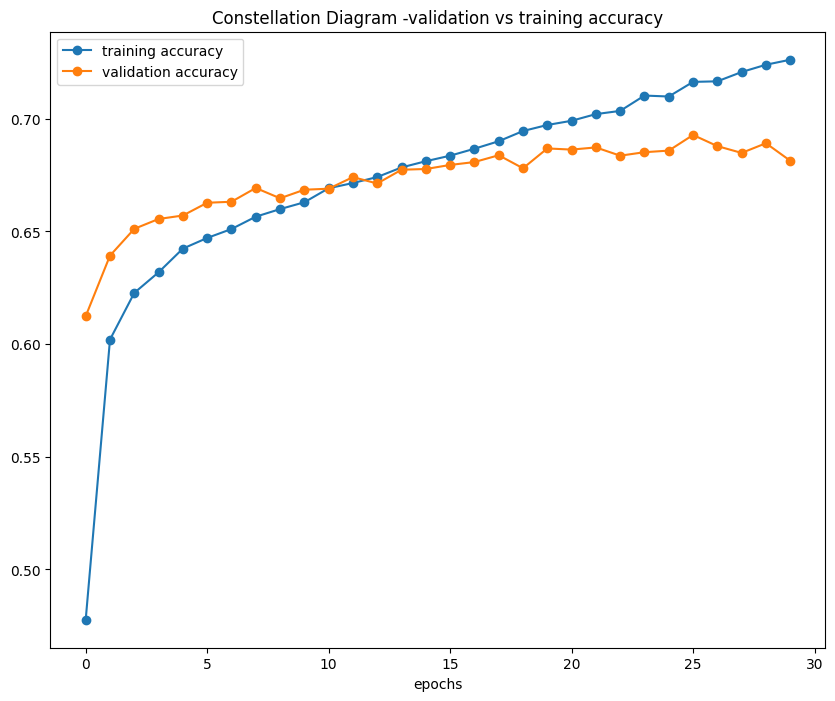

None

376/376 [==============================] - 2s 5ms/step


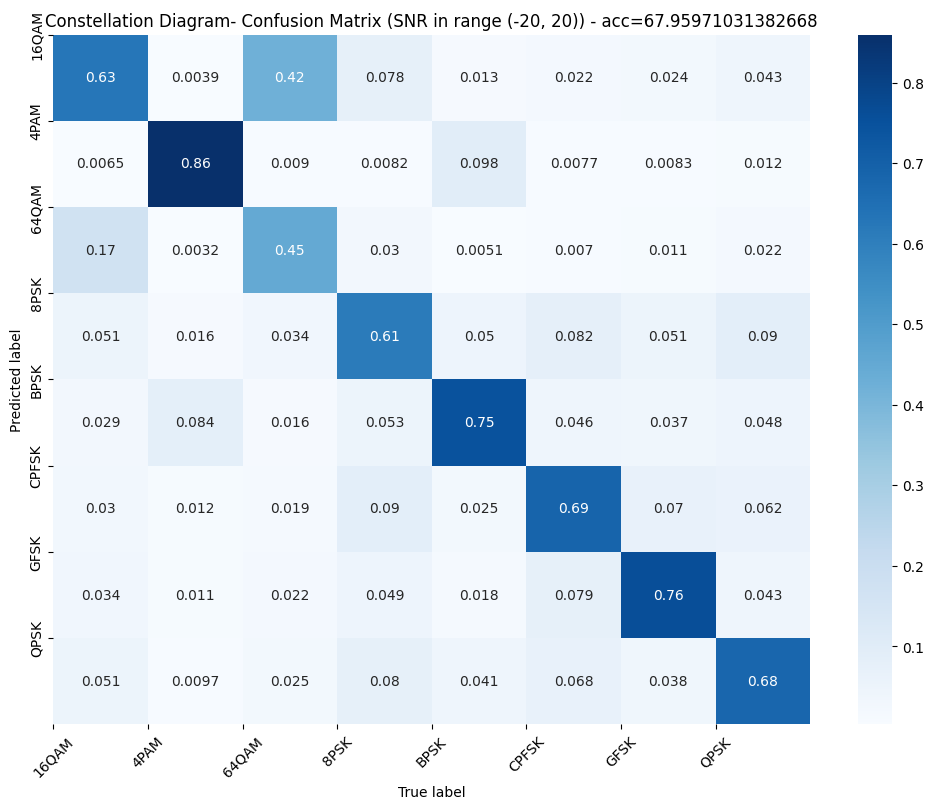

25/25 [==============================] - 0s 4ms/step


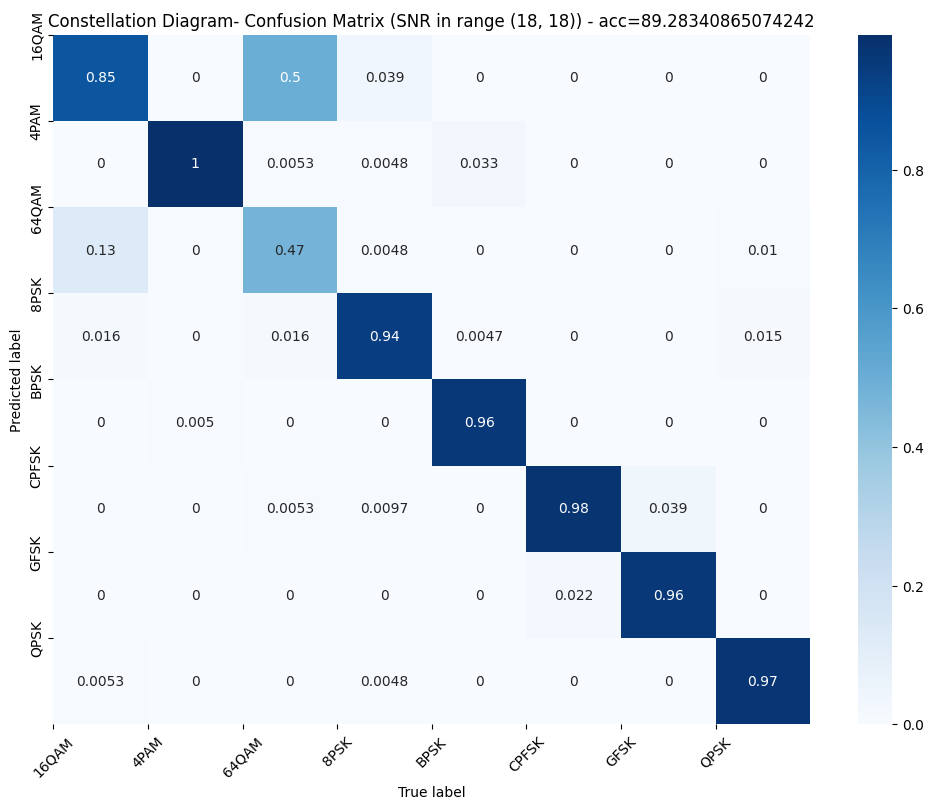

176/176 [==============================] - 1s 5ms/step


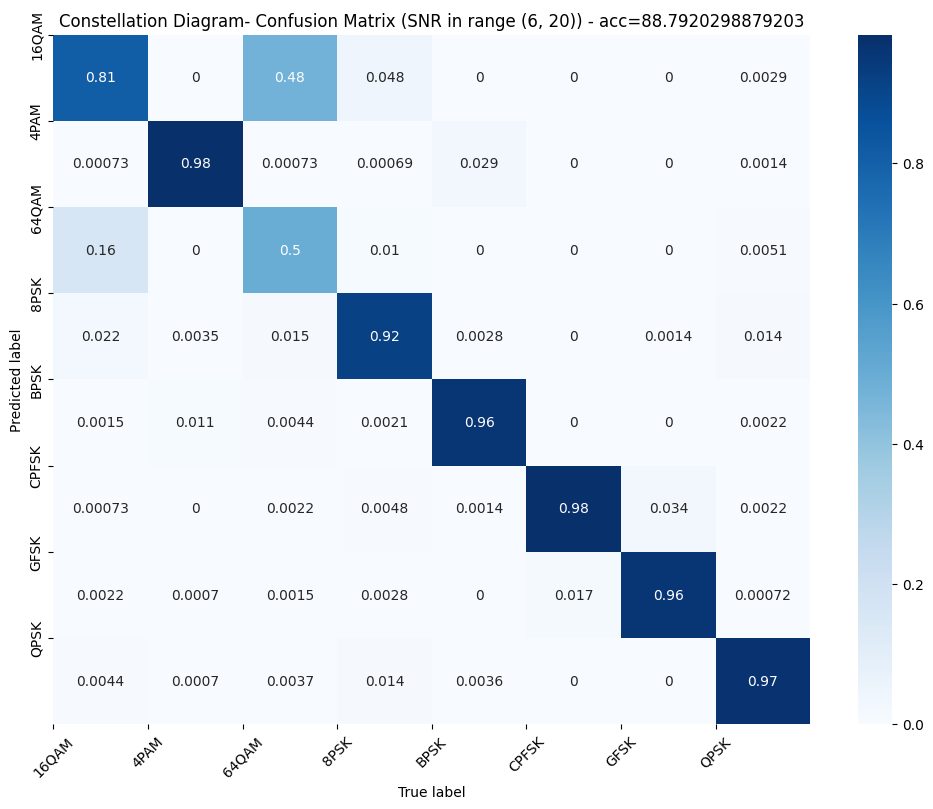

25/25 [==============================] - 0s 4ms/step


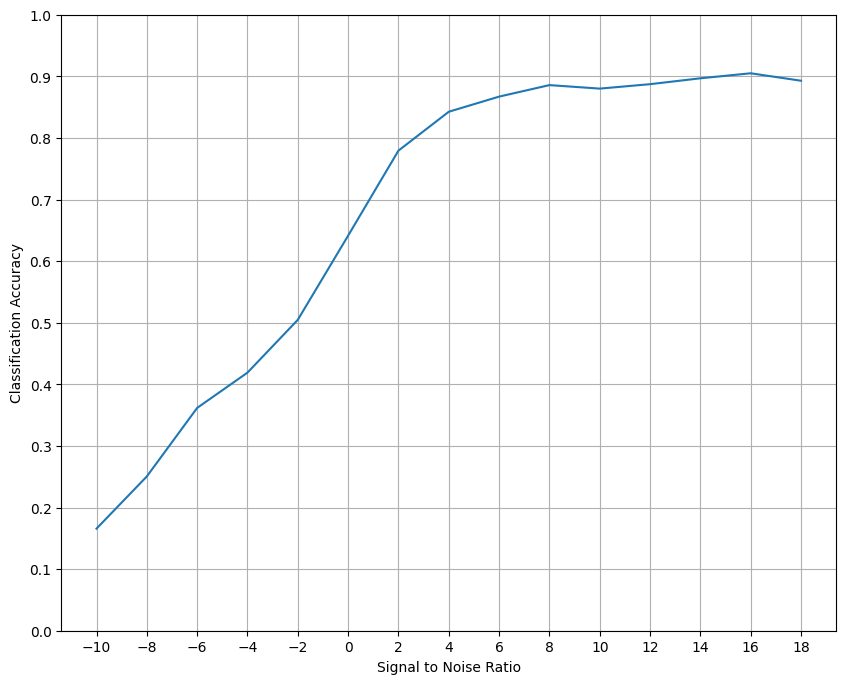

In [ ]:
constellation_32_0_model = build_constellation_net(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
constellation_32_0_model_evaluater = ModelEvaluater(constellation_32_0_model, X_img_train, y_img_train, X_img_val, y_img_val, X_img_test, y_img_test, labels_img_test, BATCH_SIZE, 'Constellation Diagram' )
constellation_32_0_model_evaluater.fit(EPOCHS,patience=PATIENCE)
acc320 = constellation_32_0_model_evaluater.accpersnr_model()
constellation_32_0_model_evaluater.print_summary()

## Training on 32x32 gray images

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 32)         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1253/1257 [============================>.] - ETA: 0s - loss: 0.9625 - accuracy: 0.6011
Epoch 2: val_loss improved from 0.93067 to 0.88296, saving model to /content/gdrive/My Drive/mod_rec/Gray Image-weights-2.hdf5
1257/1257 [==============================] - 11s 9ms/step - loss: 0.9625 - accuracy: 0.6011 - val_loss: 0.8830 - val_accuracy: 0.6378
Epoch 3/100
1256/1257 [============================>.] - ETA: 0s - loss: 0.8997 - accuracy: 0.6221
Epoch 3: val_loss improved from 0.88296 to 0.85844, saving model to /content/gdrive/My Drive/mod_rec/Gray Image-weights-3.hdf5
1257/1257 [==============================] - 12s 10ms/step - loss: 0.8998 - accuracy: 0.6220 - val_loss: 0.8584 - val_accuracy: 0.6393
Epoch 4/100
1252/1257 [============================>.] - ETA: 0s - loss: 0.8706 - accuracy: 0.6347
Epoch 4: val_loss improved from 0.85844 to 0.83174, saving model to /content/gdrive/My Drive/mod_rec/Gray Image-weights-4.hdf5
1257/1257 [==============================] - 11s 9ms/step - loss:

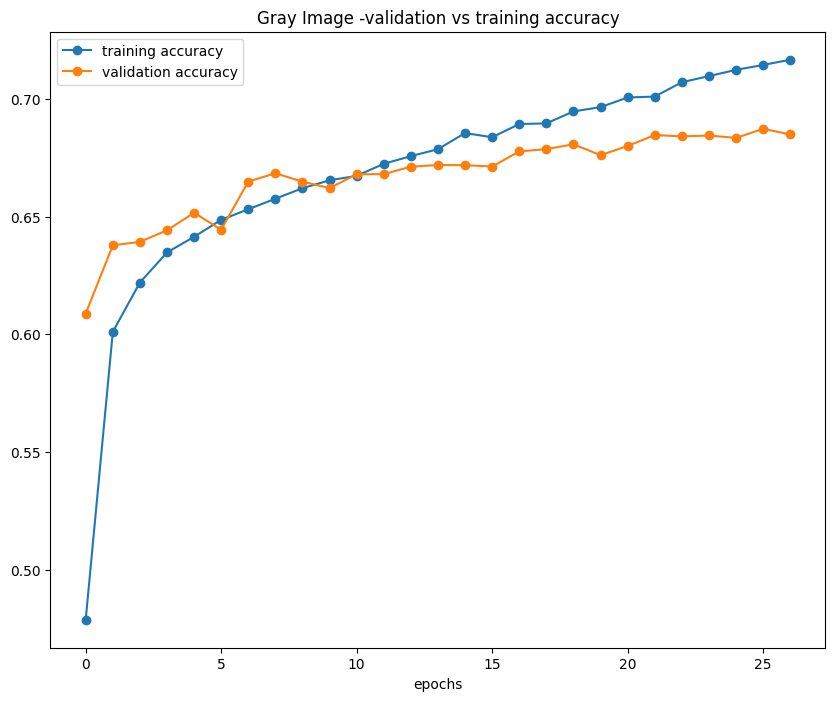

None

376/376 [==============================] - 1s 3ms/step


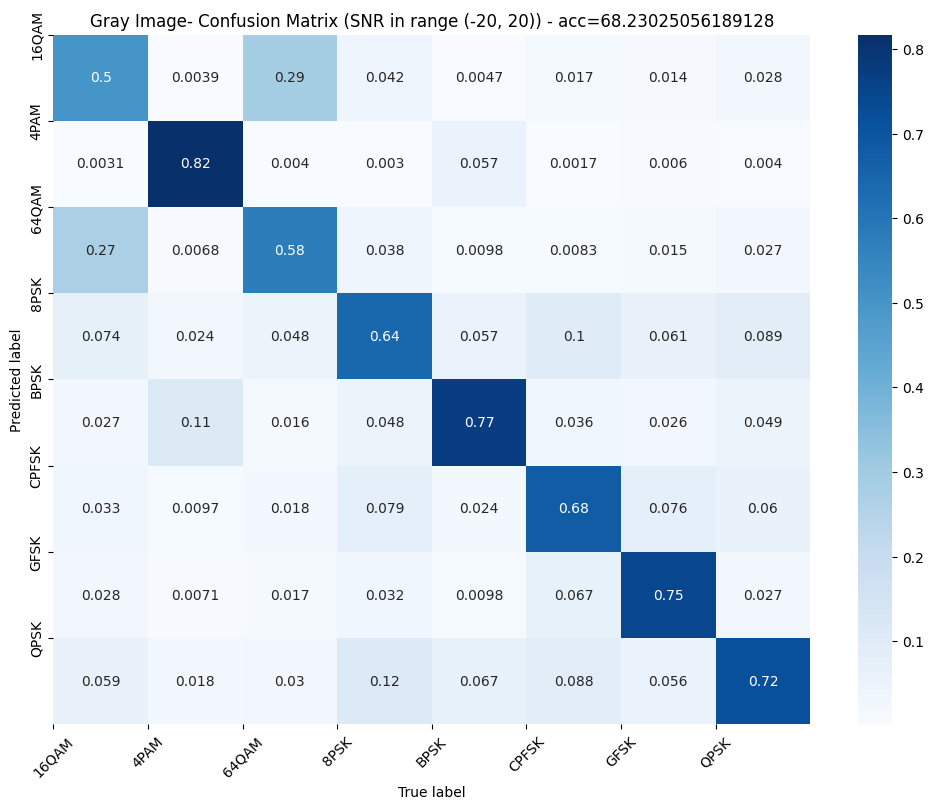

25/25 [==============================] - 0s 3ms/step


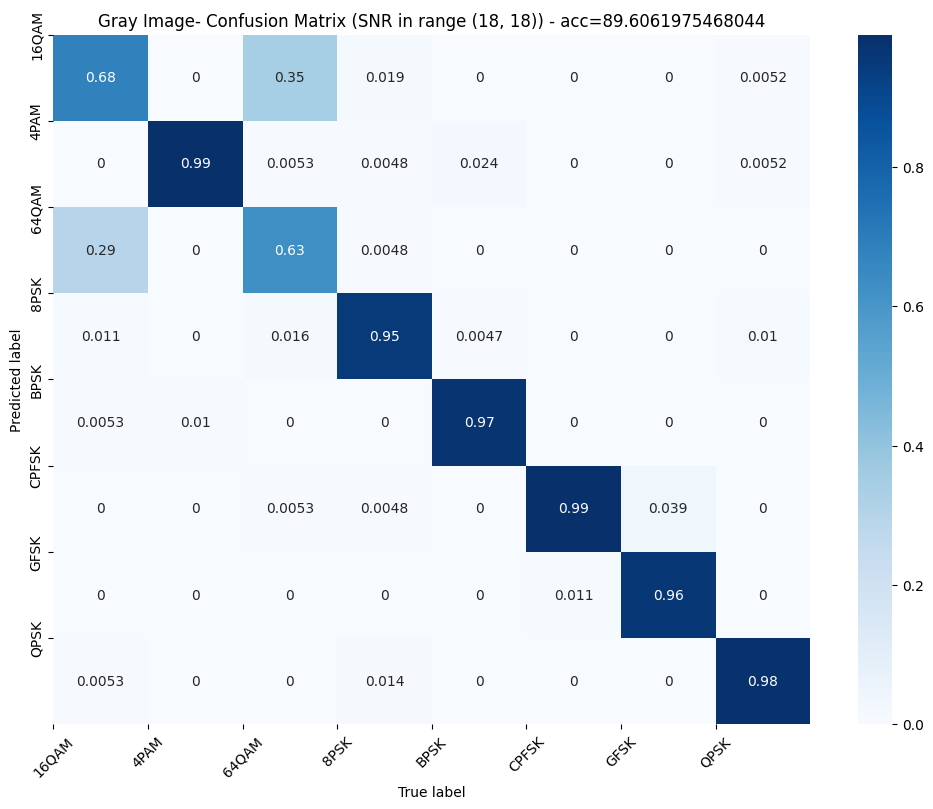

176/176 [==============================] - 1s 3ms/step


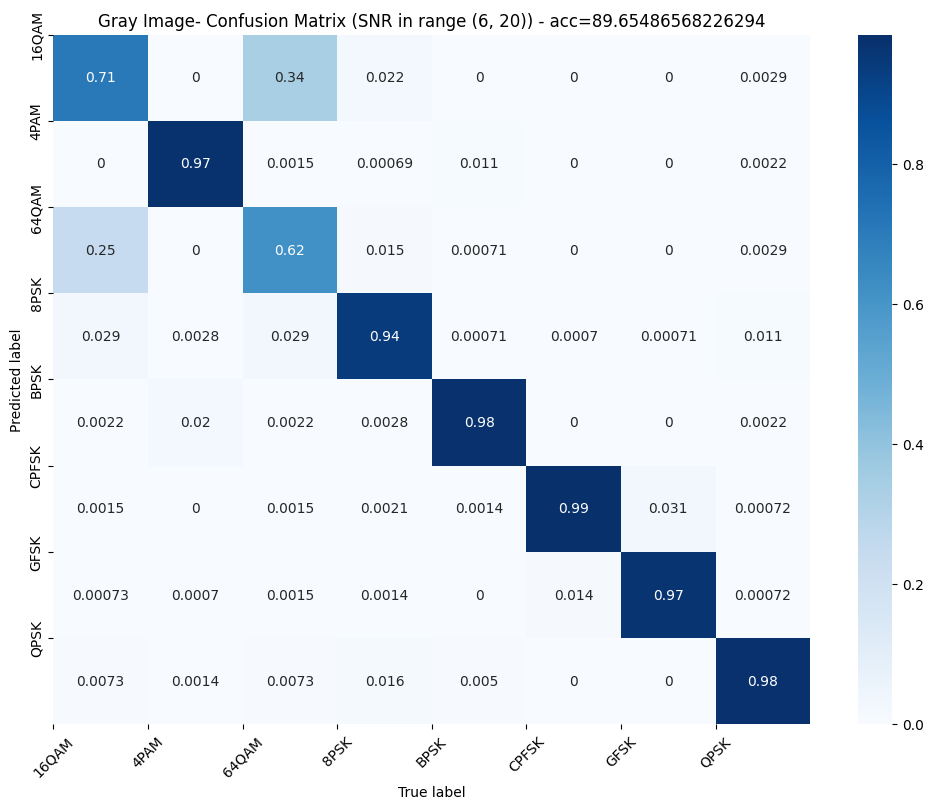

25/25 [==============================] - 0s 3ms/step


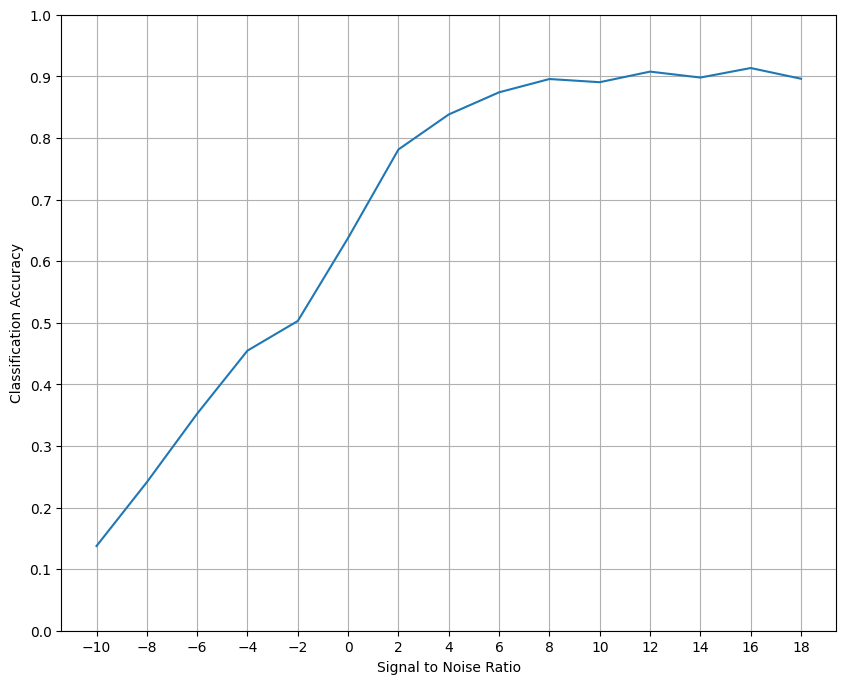

In [ ]:
constellation_32_1_model = build_constellation_net(X_img_train.shape[1], X_img_train.shape[2], X_img_train.shape[3])
constellation_32_1_model_evaluater = ModelEvaluater(constellation_32_1_model, X_img_train, y_img_train, X_img_val, y_img_val, X_img_test, y_img_test, labels_img_test, BATCH_SIZE, 'Gray Image' )
constellation_32_1_model_evaluater.fit(EPOCHS,patience=PATIENCE)
acc321 = constellation_32_1_model_evaluater.accpersnr_model()
constellation_32_1_model_evaluater.print_summary()

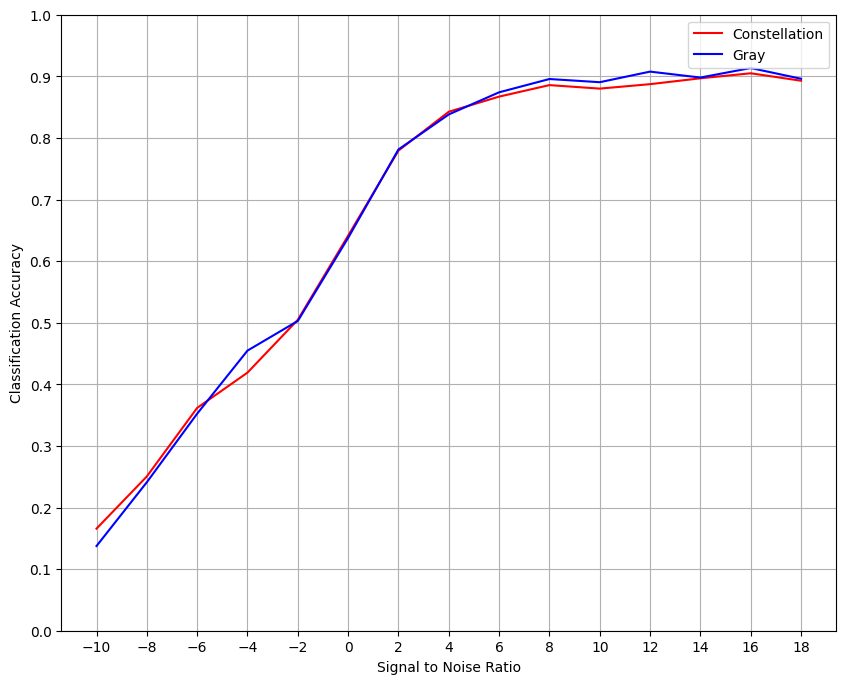

In [ ]:
# plot acc-vs-snr graphs for different models
_acc320,  = plt.plot(list(acc320.keys()),list(acc320.values()), 'r-', label='Constellation')
_acc321,  = plt.plot(list(acc321.keys()),list(acc321.values()), 'b-', label='Gray')

plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.xticks(list(acc321.keys()))
plt.legend(handles = [_acc320, _acc321])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True)
plt.show()